In [8]:
import os
os.environ['USE_PYGEOS'] = '0'

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from tqdm.auto import tqdm

import PIL
from PIL import Image
import rasterio

import scipy.stats as stats

from pyrosm import OSM
from pyrosm import get_data
from pyrosm.data import sources

In [ ]:
tif_file = rasterio.open('population/population_heatmap.tif')
heatmap = tif_file.read() + 200
heatmap /= heatmap.max()
heatmap = heatmap.squeeze(0)

In [3]:
print(heatmap.shape)
print(heatmap.min())
print(heatmap.max())

(18000, 36082)
0.0
1.0


In [4]:
heatmap_img = np.uint8(heatmap * 255)
print(heatmap_img.shape)
heatmap_img = Image.fromarray(heatmap_img)
heatmap_img = heatmap_img.resize((512, 512))
heatmap_img.show()

(18000, 36082)


In [7]:
from multiprocessing import Process
from gen_points import gen_points
for i in range(6):
    t = Process(target=gen_points, args=(heatmap, i))
    t.start()

Predicting
Predicting(0.97%)
Predicting(0.99%)
Predicting(1.98%)1/18000 (0.12%)
Predicting(1.98%)40/18000 (2.44%)
Predicting(3.03%))


In [42]:
points = np.load('points.npy')
for i in range(0, 6):
    points = np.concatenate((points, np.load(f'points_{i}.npy')))

In [46]:
points.shape

(63527, 2)

In [44]:
np.save('points.npy', points)

In [33]:

points /= 100
points[:, 0] -= 180
points[:, 1] -= 90
points[:, 1] *= -1
points *= 10**5

In [4]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# world = world[(world.pop_est>0) & (world.name!="Antarctica")]
# world = world.iloc[world.idx == 0]

In [34]:
coords_df = gpd.GeoDataFrame(geometry=[Point(point[0], point[1]) for point in points])
coords_df.crs = 'ESRI:54009'
coords_df.to_crs(world.crs, inplace=True)
print(world.crs)


EPSG:4326


In [50]:
for i, point in enumerate(coords_df.geometry):
    if not world.contains(point).any():
        coords_df.drop(i, inplace=True)

In [51]:
coords_df = coords_df.reindex()

In [40]:
coords_df.to_pickle('coords_df.pkl')

In [5]:
china = world[world['name'] == 'China'].geometry
for i, point in enumerate(coords_df.geometry):
    if china.contains(point).all():
        coords_df.iloc[i] = None
        # coords_df.drop(index=i, inplace=True)

coords_df = coords_df.reindex()

<AxesSubplot: >

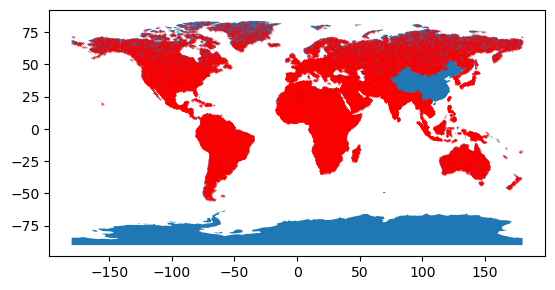

In [6]:
world_plot = world.plot()
coords_df.plot(ax=world_plot, marker='o', color='red', markersize=0.05)

In [2]:
coords_df = pd.read_pickle('coords_df.pkl')

In [14]:
sources.available.keys()

dict_keys(['africa', 'antarctica', 'asia', 'australia_oceania', 'central_america', 'europe', 'north_america', 'south_america', 'cities', 'subregions'])

In [15]:
# Initialize the OSM parser object
# for point in coords_df.geometry:
point = coords_df.geometry[0]
x, y = point.x, point.y
fp = get_data('algeria')
print("LOADING OSM")
osm = OSM(fp)
print("OSM LOADED")
print("LOADING DRIVE NET")
drive_net = osm.get_network(network_type="driving")
print("DRIVE NET LOADED")
print(fp)


Downloaded Protobuf data 'algeria-latest.osm.pbf' (113.1 MB) to:
'/local_scratch/pbs.98062.pbs02/pyrosm/algeria-latest.osm.pbf'
LOADING OSM
OSM LOADED
LOADING DRIVE NET


TypeError: Input must be valid geometry objects: MULTILINESTRING ((-0.638 35.705, -0.638 35.705), (-0.638 35.705, -0.638 35.706), (-0.638 35.706, -0.639 35.706), (-0.639 35.706, -0.639 35.706), (-0.639 35.706, -0.639 35.706), (-0.639 35.706, -0.639 35.706))

In [13]:
drive_net.sindex

In [109]:
offset = 0.1
coords = Point(26.95, 60.53)
# bbox = [coords[0]-offset, coords[1]-offset, coords[0]+offset, coords[1]+offset]

In [110]:
drive_net.sindex.nearest(coords)


array([[0],
       [3]])

In [111]:
# line = drive_net.iloc[175].geometry.union
line = drive_net.geometry.unary_union
# print(line)

/Users/alexanderkorte/mambaforge/envs/ml/lib/python3.8/site-packages/pygeos/set_operations.py:388: RuntimeWarning: invalid value encountered in unary_union
  result = lib.unary_union(collections, **kwargs)


In [118]:
%time rectified_coords = line.interpolate(line.project(coords))

CPU times: user 171 µs, sys: 263 µs, total: 434 µs
Wall time: 344 µs


In [116]:
coords_df

,name,geometry
0,Original,POINT (26.95000 60.53000)
1,Rectified,POINT (26.95049 60.52938)


In [114]:
print(drive_net.crs)

epsg:4326


<AxesSubplot: >

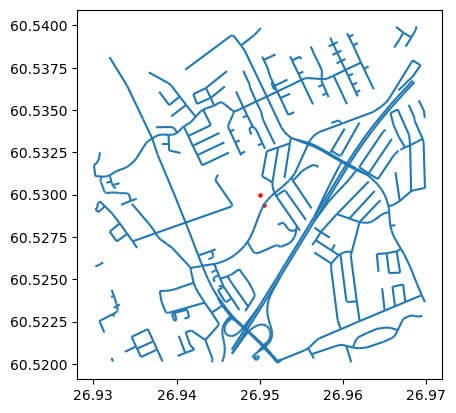

In [117]:
drive_net_plot = drive_net.plot()
coords_df = gpd.GeoDataFrame({'name': ['Original', 'Rectified'], 'geometry': [coords, rectified_coords]})
coords_df.crs = drive_net.crs
coords_df.plot(ax=drive_net_plot, marker='o', color='red', markersize=5)